# Exercise 6: Network inference from data (DL 20 October)

Lecturer: Antti Honkela

Your name:

Name of your pair:

In this exercise you will experiment with methods for inferring regulatory interactions.

If you have any questions, please post them to the Moodle discussion area!

# Task 1: Regulatory interaction inference with Gaussian Markov random field (2 pts)

In this task, you will generate a sparse Erdős–Rényi random graph, form the corresponding Gaussian Markov random field and study its covariance.

## a) Generating a graph.

Generate an undirected ER random graph for 12 genes using p=0.4. Construct a corresponding Gaussian Markov random field by forming the precision matrix which has non-zero elements corresponding to the edges of the graph. Make sure the precision matrix is positive definite by making the diagonal elements positive and sufficiently large compared to the other elements of the matrix.

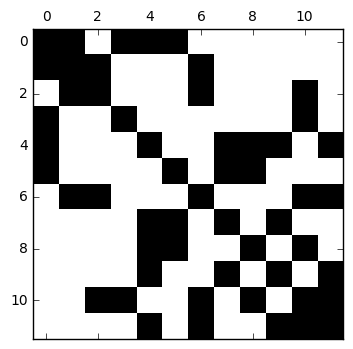

In [5]:
%matplotlib inline
# Import some useful modules
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import networkx as nx

# Generate graph for 12 genes using p=0.4
G = nx.erdos_renyi_graph(12, 0.4)
#Adjacenz matrix (undirected so both directions considered) precision matrix
precisionMatrix = np.zeros((12,12))
for e in G.edges():
    covarianceValue = npr.normal(1,1) #u=1; sig=1
    precisionMatrix[e[0]][e[1]] = covarianceValue
    precisionMatrix[e[1]][e[0]] = covarianceValue
                               
#Make sure the precision matrix is positive definite
eigenVals = np.linalg.eigvals(precisionMatrix)  
while any(val <= 0 for val in eigenVals):
    for i in range(len(precisionMatrix)):
        precisionMatrix[i][i] += 1
        eigenVals = np.linalg.eigvals(precisionMatrix) 

plt.figure(1)
plt.spy(precisionMatrix)

# TODO: Check Result. And if its right what i did ;)

## b) The covariance matrix.
Compute the covariance matrix among the 12 genes from the precision matrix. Visualise the matrix. 

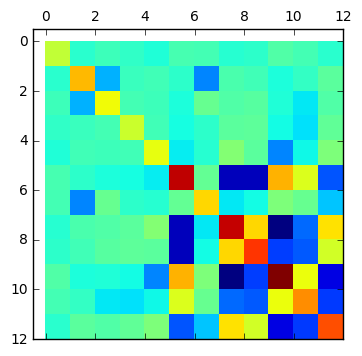

In [7]:
covarianceMatrix = np.linalg.inv(precisionMatrix)
plt.figure(1)
plt.spy(covarianceMatrix)
plt.pcolor(covarianceMatrix) # todo: fix lable

# TODO: Check Result. And if its right what i did ;)
# Use np.cov() an plot this in comparison?

**Can you spot the true connections?**

Answer:
TODO:


## c) Estimating connections from the covariance.

Try setting a threshold for absolute values of the covariance matrix elements to distinguish between correct and false connections. Use the Hamming distance between the true and estimated connectivity matrices as a measure of accuracy.


smallestHammingDistance: 34
smallestHammingDistanceThreshold: 0.06500000000000093
smallestHammingDistanceMatrix:


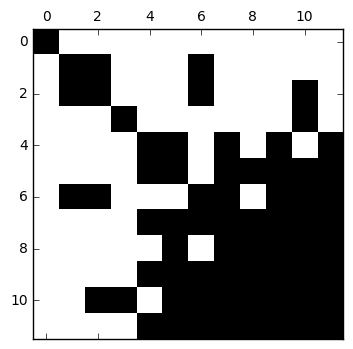

In [13]:
#threshold matrix
def getThresholdCovarianzMatrix(matrix, threshold):
    thresholdCovarianceMatrix = np.copy(matrix)
    for row in range(len(thresholdCovarianceMatrix)):
        for col in range(len(thresholdCovarianceMatrix[0])):
            if abs(thresholdCovarianceMatrix[row][col]) < threshold:
                thresholdCovarianceMatrix[row][col] = 0
    return thresholdCovarianceMatrix

#get hammingDistance 
def hammingDistance(M1,M2):
    hammingDistance = 0   
    for row in range(len(M1)):
        for col in range(len(M1[0])):  
            if M1[row][col] != 0 and M2[row][col] == 0:
                hammingDistance += 1
            if M2[row][col] != 0 and M1[row][col] == 0:
                hammingDistance += 1
    return hammingDistance

def getASmallHammingDistance(covarianceMatrix,precisionMatrix):
    threshold = -1 #0 #TODO: or get minimum value of matix?!
    smallestHammingDistance = 144 #most bad: 12*12=144 (every element differs!)
    smallestHammingDistanceThreshold = 0
    smallestHammingDistanceMatrix = []
    numberOfRuns = 10000
    # Try some time to get a good values / suitable threshold / small hemming distance
    for i in range(numberOfRuns):
        tmpThresholdCovarianceMatrix = getThresholdCovarianzMatrix(covarianceMatrix,threshold)    
        tmpHammingDistance = hammingDistance(tmpThresholdCovarianceMatrix,precisionMatrix)#Are this the right matrixes to compare?

        #TODO: why this point is only reached ones?! > Results always same?! doesnt make sence.... 
        if tmpHammingDistance < smallestHammingDistance:
            smallestHammingDistance = tmpHammingDistance
            smallestHammingDistanceThreshold = threshold
            smallestHammingDistanceMatrix = tmpThresholdCovarianceMatrix

        threshold += 0.001 #increase threshold by some small value
    return smallestHammingDistance,smallestHammingDistanceThreshold,smallestHammingDistanceMatrix

# Format of result: [smallestHammingDistance,smallestHammingDistanceThreshold,smallestHammingDistanceMatrix]
result = getASmallHammingDistance(covarianceMatrix,precisionMatrix)
smallestHammingDistance = result[0]
smallestHammingDistanceThreshold = result[1]
smallestHammingDistanceMatrix = result[2]
print('smallestHammingDistance:',smallestHammingDistance)
print('smallestHammingDistanceThreshold:',smallestHammingDistanceThreshold)
print('smallestHammingDistanceMatrix:')
plt.figure(1)
plt.spy(smallestHammingDistanceMatrix)
    
# TODO: Check Result. And if its right what i did ;)       

### How small a Hamming distance can you achieve?
Answer:
TODO

Hints:

* You can check if the precision matrix is positive definite using `np.linalg.eigvals()`. This returns the eigenvalues of the matrix which should all be positive. Eigenvalues of a symmetric matrix are always real. If you get complex eigenvalues, make sure the matrix is symmetric. (Precision and covariance matrices of Gaussian distributions are always symmetric.)
* You can force a matrix $\mathbf{A}$ to be positive definite by adding a diagonal term. If eigenvalues of $\mathbf{A}$ are $(\lambda_1, \dots, \lambda_n)$, eigenvalues of $\mathbf{A} + \alpha \mathbf{I}$ are $(\lambda_1+\alpha, \dots, \lambda_n+\alpha)$.
* `plt.spy()` function can be useful for exploring the sparsity pattern of matrices.
* Hamming distance of the binary connectivity matrices is the number of positions in which their values are different.

# Task 2: Inferring interactions from data (3 pts)

In this task, you will simulate observations from the Gaussian Markov random field model constructed in Task 1 and attempt to infer the network structure using those observations.

## a) Simulate data.
Simulate three multivariate normal observation data sets of sizes [25, 50, 100] with 0 mean using the covariance from Task 1.


In [16]:
simulation1 = []
simulation2 = []
simulation3 = []
mean = [0] * 12
for i in range(25):
    simulation1.append(np.random.multivariate_normal(mean, smallestHammingDistanceMatrix))
for i in range(50):
    simulation2.append(np.random.multivariate_normal(mean, smallestHammingDistanceMatrix))
for i in range(100):
    simulation3.append(np.random.multivariate_normal(mean, smallestHammingDistanceMatrix))

## b) Visualise the correlation matrices.
Compute and visualise the correlation matrix among the 12 genes simulated. How small Hamming distance can you obtain with the different data sets using a suitable threshold?


simulation1 - smallestHammingDistance: 30
simulation2 - smallestHammingDistance: 32
simulation3 - smallestHammingDistance: 28


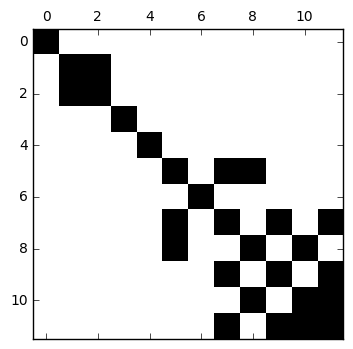

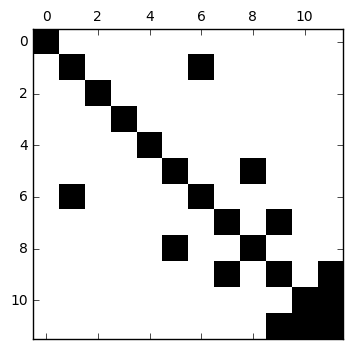

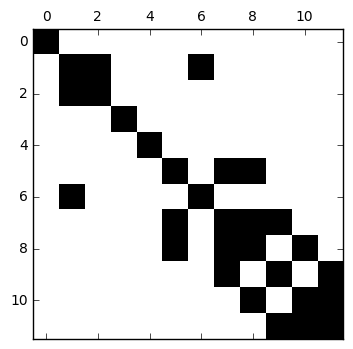

In [17]:
correlationMatrix_simulation1 = np.corrcoef(np.transpose(np.array(simulation1)))
correlationMatrix_simulation2 = np.corrcoef(np.transpose(np.array(simulation2)))
correlationMatrix_simulation3 = np.corrcoef(np.transpose(np.array(simulation3)))

result1 = getASmallHammingDistance(correlationMatrix_simulation1,precisionMatrix)
result2 = getASmallHammingDistance(correlationMatrix_simulation2,precisionMatrix)
result3 = getASmallHammingDistance(correlationMatrix_simulation3,precisionMatrix)

print('simulation1 - smallestHammingDistance:',result1[0])
print('simulation2 - smallestHammingDistance:',result2[0])
print('simulation3 - smallestHammingDistance:',result3[0])

plt.figure(1)
plt.spy(result1[2])
plt.figure(2)
plt.spy(result2[2])
plt.figure(3)
plt.spy(result3[2])

## c) Visualise the precision matrices.
Compute and visualise the inverse of the correlation matrix. How small Hamming distance can you now obtain with the different data sets using a suitable threshold?


simulation1 - smallestHammingDistance: 30
simulation2 - smallestHammingDistance: 33
simulation3 - smallestHammingDistance: 20


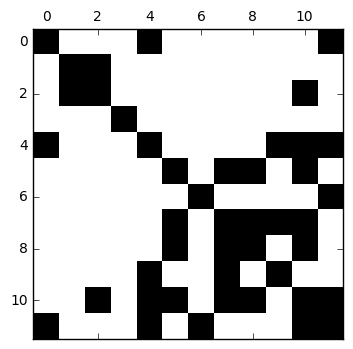

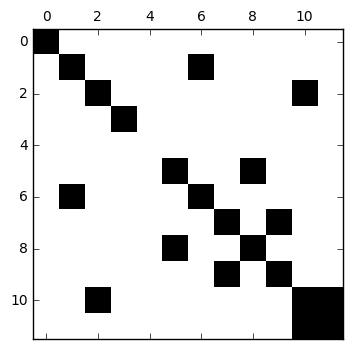

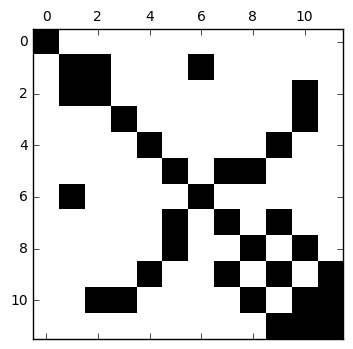

In [18]:
InverseCorrelationMatrix_simulation1 = np.linalg.inv(correlationMatrix_simulation1)
InverseCorrelationMatrix_simulation2 = np.linalg.inv(correlationMatrix_simulation2)
InverseCorrelationMatrix_simulation3 = np.linalg.inv(correlationMatrix_simulation3)

result1 = getASmallHammingDistance(InverseCorrelationMatrix_simulation1,precisionMatrix)
result2 = getASmallHammingDistance(InverseCorrelationMatrix_simulation2,precisionMatrix)
result3 = getASmallHammingDistance(InverseCorrelationMatrix_simulation3,precisionMatrix)

print('simulation1 - smallestHammingDistance:',result1[0])
print('simulation2 - smallestHammingDistance:',result2[0])
print('simulation3 - smallestHammingDistance:',result3[0])

plt.figure(1)
plt.spy(result1[2])
plt.figure(2)
plt.spy(result2[2])
plt.figure(3)
plt.spy(result3[2])

## d) Structure learning using the graphical lasso.
Learn the structure using graphical lasso (`sklearn.covariance.graph_lasso()`). Try different values of the regularisation parameter. How good results in terms of the Hamming distance can you now obtain?


In [4]:
# http://scikit-learn.org/stable/modules/generated/sklearn.covariance.graph_lasso.html
import sklearn.covariance as sk
#sk.graph_lasso()
# TODO: Play with some parameters

## e) Comparison of the different approaches.

**How good results did you obtain with the different approaches?**

Answer:
TODO

### Hints:

* See hints for Task 1 about positive definiteness of the covariance matrix.
* Graphical lasso is implemented in scikit-learn. You can install the package using the command "`pip3 install sklearn --user`" on the command line. If this does not work, more instructions are at: http://scikit-learn.org/

# Task 3: Inferring interactions from data II (2 pts)

In this task, you will simulate observations using a linear generative model:
$$ \mathbf{y_i} = \mathbf{A} \mathbf{x_i} + \epsilon_i. $$
Here $\mathbf{x_i}$ are TF expression levels (assumed to be random, following a Gaussian distribution), $\mathbf{A}$ is the connectivity matrix from TFs to target genes, $\mathbf{y_i}$ are the target gene expression levels and $\epsilon_i$ is Gaussian observation noise. Based on these data, you will attempt to infer the network structure.

## a) Generate the graph.
Generate a sparse Erdős–Rényi random connectivity graph from 3 TFs to 9 target genes and sample the random connection weights having this sparsity pattern.


In [ ]:
G = nx.erdos_renyi_graph(12, 0.4)

## b) Simulate the TFs and targets.
Simulate 3 data sets following the above connectivity graph and model with 3 TFs and 9 target genes, having [25, 50, 100] samples. You can simulate $\mathbf{x_i}$ from $\mathcal{N}(0, 1)$ and $\epsilon_i$ from $\mathcal{N}(0, 0.1^2)$.


In [ ]:
# Your code here

## c) Correlation matrix analysis.
Form a data set by concatenating the TFs and targets. Compute and visualise the correlation matrix among the 12 genes. How small Hamming distance between the true network and the estimated network can you obtain?


In [ ]:
# Your code here

## d) Precision matrix analysis.
Compute and visualise the inverse of the correlation matrix. How well can you now find the true connections in terms of the Hamming distance?


In [ ]:
# Your code here

### Hints:

* When computing covariances, it can be useful to check the shape of the result that you are computing it the right way. You can then transpose the data (`X` -> `X.T`) if necessary.

# Task 4: Inferring interactions from dynamic simulations (3 pts)

In this task, you will simulate observations using the following dynamical model:
$$ \frac{d \mathbf{x}(t)}{dt} = \sigma(\mathbf{A} \mathbf{x}) - \delta \mathbf{x} + \gamma, $$
where $\mathbf{x}$ are the gene expression levels, $\mathbf{A}$ is the connectivity matrix (connecting only TFs to TFs and TFs to targets), $\sigma(x) = 1/(1+e^{-x})$ is a sigmoid function, $\delta$ are the mRNA degradation rates and $\gamma$ are constant external inputs (affecting only TFs).

## a) Simulate the system
Implement a function for simulating from the above system. You can use `scipy.integrate.odeint()` to numerically solve the differential equation given a suitable non-negative initial state.

Pick a plausible connectivity matrix with 3 TFs and 9 target genes that includes different combinations of TFs regulating different targets and also some negative connection weights. Simulate the system with a constant non-negative external input and $\delta = 1$ and visualise the results.


In [ ]:
# Your code here

## b) Simulate with different inputs
Simulate the system with number of non-negative random external inputs until it reaches steady state. What can you see?


In [ ]:
# Your code here

## c) Infer the network structure
Compute the correlations and inverse covariance for the combined steady-state measurements from [10, 20, 40] simulations. Can you recover the true connections?

In [ ]:
# Your code here

**How well can you recover the true connections?**

Your answer:

### Background on Task 4

The use of sigmoid function in the dynamics as in this task is not very common. It has clear advantages over plain linear model (saturation of transcription rate to a fixed maximum, possibly easier stability guarantees, possibility to model repression), but the presented formulation still cannot realistically model combinatorial regulation, and it makes model inference much more difficult than linear differential equations.